# Fit emimTF2N data

EoS: PR

Parameter T dependence: Linear in [R32, emimTF2N] direction

N (total fitting parameters): 3

## Import Functions

In [1]:
import idaes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import sys
sys.path.append('../')

from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)
from pyomo.opt import TerminationCondition, SolverStatus

from idaes.core import FlowsheetBlock
import idaes.logger as idaeslog
# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)
# Import unit models from the model library
from idaes.generic_models.unit_models import Flash
# Import degrees of freedom tool
from idaes.core.util.model_statistics import degrees_of_freedom

# parmest (binary_param2)
from bip_fitting_functions import linear

import scipy.stats as stats

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches

## Load Data

In [2]:
data_full = pd.read_csv('r32_emimtf2n_full.csv')
data_subset = pd.read_csv('r32_emimtf2n_subset.csv')

## Load Configuration + Check DOF

In [3]:
from hfc32_emimtf2n_PR import configuration 

In [4]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.properties = GenericParameterBlock(default=configuration)
m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})
DOF_initial = degrees_of_freedom(m)
print('The initial DOF is {0}'.format(DOF_initial))

    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in 7.0) (called from /Users/bridgettebefort/Dowling-
    Maginn-Lab/DowlingLab/IL-MD/idaes-
    pse/idaes/generic_models/properties/core/state_definitions/FTPx.py:178)
    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in 7.0) (called from /Users/bridgettebefort/Dowling-
    Maginn-Lab/DowlingLab/IL-MD/idaes-
    pse/idaes/generic_models/properties/core/state_definitions/FTPx.py:176)
The initial DOF is 7


## Fit Parameters

In [5]:
parameters, obj_value, a = linear(data_subset, configuration, 'R32', 'emimTf2N', "x_R32", "x_emimTf2N", 
    init_temp =  283.1, init_press =   399300 , init_x_c1 =    0.448, init_x_c2 = 0.552,
    init_kappa_2_1A = -0.1, init_kappa_1_2A = 0.1,
    init_kappa_2_1B = 0.0, init_kappa_1_2B = -0.05, eps = 0.1, scaling_fac = 1e-9,optional_params = 'Opt1')

2021-09-30 09:48:10 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-09-30 09:48:11 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-09-30 09:48:11 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-09-30 09:48:12 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-09-30 09:48:12 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-09-30 09:48:12 [INFO] idaes.init.fs.state_block: Property package initialization: infeasible - Converged to a locally infeasible point. Problem may be infeasible..
2021-09-30 09:48:13 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-09-30 09:48:13 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal 

The SSE at the optimal solution is 0.206399

The values for the parameters are as follows:
fs.properties.PR_kappa_A[R32,emimTf2N] = 0.05611524793576
fs.properties.PR_kappa_A[emimTf2N,R32] = -0.11697708556353181
fs.properties.PR_kappa_B[R32,emimTf2N] = -0.09822243622026108
covariance_matrix                                         fs.properties.PR_kappa_A[R32,emimTf2N]  \
fs.properties.PR_kappa_A[R32,emimTf2N]                                0.000245   
fs.properties.PR_kappa_A[emimTf2N,R32]                                0.000196   
fs.properties.PR_kappa_B[R32,emimTf2N]                               -0.000213   

                                        fs.properties.PR_kappa_A[emimTf2N,R32]  \
fs.properties.PR_kappa_A[R32,emimTf2N]                                0.000196   
fs.properties.PR_kappa_A[emimTf2N,R32]                                0.000263   
fs.properties.PR_kappa_B[R32,emimTf2N]                               -0.000162   

                                        fs.properti

/anaconda3/envs/idaes-pse-dev/lib/python3.9/site-packages/pyomo/contrib/interior_point/interface.py:418: RuntimeWarning: divide by zero encountered in true_divide
  data = (duals_primals_lb/(primals - self._nlp.primals_lb()) +


In [6]:
print('Objective (SSE):',obj_value)

Objective (SSE): 0.20639855231407989


In [7]:
cov = np.array(a)
print('Covariance Matrix:')
print(cov)

Covariance Matrix:
[[ 0.00024498  0.0001957  -0.00021327]
 [ 0.0001957   0.00026276 -0.00016172]
 [-0.00021327 -0.00016172  0.00018684]]


## Apply Parameters + Plot

In [8]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [9]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)

m.fs.properties.PR_kappa_A['R32','emimTf2N'] = parameters['fs.properties.PR_kappa_A[R32,emimTf2N]']
m.fs.properties.PR_kappa_A['emimTf2N','R32'] = parameters['fs.properties.PR_kappa_A[emimTf2N,R32]']
m.fs.properties.PR_kappa_B['R32','emimTf2N'] = parameters['fs.properties.PR_kappa_B[R32,emimTf2N]']
# m.fs.properties.PR_kappa_B['emimTf2N','R32'] = parameters['fs.properties.PR_kappa_B[emimTf2N,R32]']

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix()

R32_x = np.zeros((len(data_full)))
P = np.zeros((len(data_full)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

for i in range(len(data_full)):
    m.fs.liq = data_full["x_emimTf2N"].iloc[i]
    m.fs.F101.inlet.temperature.fix(float(data_full["temperature"].iloc[i]))
    m.fs.F101.inlet.pressure.fix(float(data_full["pressure"].iloc[i]))
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data_full["x_R32"].iloc[i])+0.1)
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(data_full["x_R32"].iloc[i]+0.1)))
    m.fs.F101.vap_outlet.temperature.fix(float(data_full["temperature"].iloc[i]))
    
#     DOF_final = degrees_of_freedom(m)
#     print("The final DOF is {0}".format(DOF_final))
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
    
    status = solver.solve(m, tee = False)

#     m.fs.F101.report()
    if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
        print(data_full["x_emimTf2N"].iloc[i])
        R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
        P[i] = value(m.fs.F101.vap_outlet.pressure[0])

    else:
        print('Infeasible.')

0.986
0.864
0.694
0.552
0.43
0.328
0.214
0.99
0.905
0.782
0.675
0.583
0.501
0.43
0.357
0.995
0.945
0.867
0.8
0.736
0.68
0.632
0.583
0.998
0.966
0.916
0.869
0.825
0.784
0.746
0.712


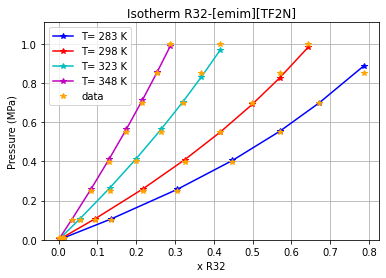

In [10]:
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

plt.plot(R32_x[0:7],P1[0:7],"b*-",label="T= 283 K")  
plt.plot(R32_x[7:15],P1[7:15],"r*-",label="T= 298 K") 
plt.plot(R32_x[15:23],P1[15:23],"c*-",label="T= 323 K") 
plt.plot(R32_x[23:31],P1[23:31],"m-*",label="T= 348 K")
plt.plot(data_full["x_R32"],data_full["pressure"]/1e6,"*",color='orange',label="data")  
plt.title('Isotherm R32-[emim][TF2N]')
plt.ylabel('Pressure (MPa)')
plt.xlabel('x R32')
plt.grid(True)
plt.ylim(0,1.110000)
plt.legend()
plt.show()

### Print Eigvals, Eigvectors

An identifiability analysis can be performed with these as well as a FIM because the covariance matrix is the inverse of the FIM. That means that if there are any eigvals > 0, their eigvecs indicate directions of un-identifiability.

In [11]:
eigvals, eigvecs = np.linalg.eig(cov)

In [12]:
eigvals

array([6.14366479e-04, 2.46480509e-07, 7.99625908e-05])

In [13]:
eigvecs

array([[-0.6150941 , -0.68287976, -0.39412496],
       [-0.58533111,  0.0605858 ,  0.80852758],
       [ 0.52824874, -0.72801414,  0.43697674]])

Conclusion: Fully identifiable because all eigvals ~ 0

## AIC Value

See https://docs.google.com/document/d/1um0r2XK4ldjjy2colOqaZsEM3wIzGD6l_3B8gnpnI2I/edit# for equations

In [14]:
n = 3

In [15]:
SSR = obj_value

In [16]:
sigma_sq = SSR/n
sigma_sq

0.06879951743802663

In [17]:
L = -n/2*np.log(2*np.pi) - n/2*np.log(sigma_sq) - 1/(2*sigma_sq)*SSR
L

-0.2419777775396057

In [18]:
AIC = 2*n - 2*L
AIC

6.483955555079211